In [1]:
from collections import defaultdict
import glob

import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from netCDF4 import Dataset
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pandas as pd
dst_crs = ccrs.NorthPolarStereo(central_longitude=-45, true_scale_latitude=70)
from pyresample.geometry import AreaDefinition

%matplotlib inline

In [2]:
idir = '/Data/sat/downloads/CS2/SIR_GDR/2021/01'

ifiles = sorted(glob.glob(f'{idir}/CS_OFFL_SIR_GDR_2__2021010[1-5]*D001.nc'))
print(len(ifiles))

68


In [83]:
!ncdump -h /Data/sat/downloads/CS2/SIR_GDR/2021/01/CS_OFFL_SIR_GDR_2__20210101T011921_20210101T025835_D001.nc

netcdf CS_OFFL_SIR_GDR_2__20210101T011921_20210101T025835_D001 {
dimensions:
	time_20_ku = 125882 ;
	time_cor_01 = 6313 ;
variables:
	int alt_01(time_cor_01) ;
		alt_01:_FillValue = -2147483648 ;
		alt_01:comment = "Altitude of satellite CoM above reference ellipsoid (WGS84)." ;
		alt_01:coordinates = "lon_01 lat_01" ;
		alt_01:long_name = "Altitude of CoM above reference ellipsoid" ;
		alt_01:scale_factor = 0.001 ;
		alt_01:standard_name = "height_above_reference_ellipsoid" ;
		alt_01:units = "m" ;
	short echo_avg_numval_20_ku(time_20_ku) ;
		echo_avg_numval_20_ku:_FillValue = -32768s ;
		echo_avg_numval_20_ku:comment = "In LRM mode this is the number of echoes which have been averaged to make one measurement (normally). In SAR and SARIn modes this is the number of Doppler beams which have been stacked to derive each measurement." ;
		echo_avg_numval_20_ku:coordinates = "lon_poca_20_ku lat_poca_20_ku" ;
		echo_avg_numval_20_ku:long_name = "count of echoes or beams averaged" ;
		echo_a

In [4]:
rho_water = 1026
rho_snow = 400
rho_ice = 917

names = ['t', 'y', 'x', 'h', 'c', 'f', 's']

orbits = defaultdict(list)
min_lat = 70
min_sic = 0
for ifile in ifiles:
    print(ifile)
    ds = Dataset(ifile)
    freeboard_20_ku = ds['freeboard_20_ku'][:]
    lat_poca_20_ku = ds['lat_poca_20_ku'][:]
    lon_poca_20_ku = ds['lon_poca_20_ku'][:]

    time_20_ku = ds['time_20_ku'][:]
    time_cor_01 = ds['time_cor_01'][:]

    snow_depth_01 = ds['snow_depth_01'][:]    
    f = interp1d(time_cor_01.filled(np.nan), snow_depth_01.filled(np.nan), bounds_error=False)
    snow_depth_20_ku = f(time_20_ku.filled(np.nan))

    sea_ice_concentration_01 = ds['sea_ice_concentration_01'][:]
    f = interp1d(time_cor_01.filled(np.nan), sea_ice_concentration_01.filled(np.nan), bounds_error=False)
    sea_ice_concentration_20_ku = f(time_20_ku.filled(np.nan))

    # filter out southern and invalid parts of orbits
    gpi1 = (lat_poca_20_ku > min_lat) * (sea_ice_concentration_20_ku > min_sic) * (~freeboard_20_ku.mask) * (freeboard_20_ku > -1)* (freeboard_20_ku < 1)
    # compute thickness
    # https://tc.copernicus.org/preprints/tc-2021-127/
    sit = (freeboard_20_ku[gpi1] * rho_water + snow_depth_20_ku[gpi1] * rho_snow) / (rho_water - rho_ice)
    # compute X, Y coordinates in meters
    x, y, _ = dst_crs.transform_points(ccrs.PlateCarree(), lon_poca_20_ku[gpi1], lat_poca_20_ku[gpi1]).T
    # filter out errors in lon, lat positions
    for name, vector in zip(
        names,
        [time_20_ku[gpi1], y, x, sit, sea_ice_concentration_20_ku[gpi1], freeboard_20_ku[gpi1], snow_depth_20_ku[gpi1]]):
        orbits[name].append(vector)
        
for n in names:
    orbits[n] = np.hstack(orbits[n])


/Data/sat/downloads/CS2/SIR_GDR/2021/01/CS_OFFL_SIR_GDR_2__20210101T011921_20210101T025835_D001.nc
/Data/sat/downloads/CS2/SIR_GDR/2021/01/CS_OFFL_SIR_GDR_2__20210101T025835_20210101T043750_D001.nc
/Data/sat/downloads/CS2/SIR_GDR/2021/01/CS_OFFL_SIR_GDR_2__20210101T043750_20210101T061705_D001.nc
/Data/sat/downloads/CS2/SIR_GDR/2021/01/CS_OFFL_SIR_GDR_2__20210101T061705_20210101T075619_D001.nc


/data1/antonk/miniconda/envs/ice/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in greater


/Data/sat/downloads/CS2/SIR_GDR/2021/01/CS_OFFL_SIR_GDR_2__20210101T075619_20210101T093534_D001.nc
/Data/sat/downloads/CS2/SIR_GDR/2021/01/CS_OFFL_SIR_GDR_2__20210101T093534_20210101T111449_D001.nc
/Data/sat/downloads/CS2/SIR_GDR/2021/01/CS_OFFL_SIR_GDR_2__20210101T111449_20210101T125403_D001.nc
/Data/sat/downloads/CS2/SIR_GDR/2021/01/CS_OFFL_SIR_GDR_2__20210101T125403_20210101T143318_D001.nc
/Data/sat/downloads/CS2/SIR_GDR/2021/01/CS_OFFL_SIR_GDR_2__20210101T143318_20210101T161233_D001.nc
/Data/sat/downloads/CS2/SIR_GDR/2021/01/CS_OFFL_SIR_GDR_2__20210101T161233_20210101T175147_D001.nc
/Data/sat/downloads/CS2/SIR_GDR/2021/01/CS_OFFL_SIR_GDR_2__20210101T175147_20210101T193102_D001.nc
/Data/sat/downloads/CS2/SIR_GDR/2021/01/CS_OFFL_SIR_GDR_2__20210101T193102_20210101T211017_D001.nc
/Data/sat/downloads/CS2/SIR_GDR/2021/01/CS_OFFL_SIR_GDR_2__20210101T211017_20210101T224931_D001.nc
/Data/sat/downloads/CS2/SIR_GDR/2021/01/CS_OFFL_SIR_GDR_2__20210101T224931_20210102T002846_D001.nc
/Data/sat/

In [5]:
odf = pd.DataFrame.from_dict(orbits)
odf.index = pd.Timestamp("2000-01-01") + pd.TimedeltaIndex(orbits['t'], "sec")

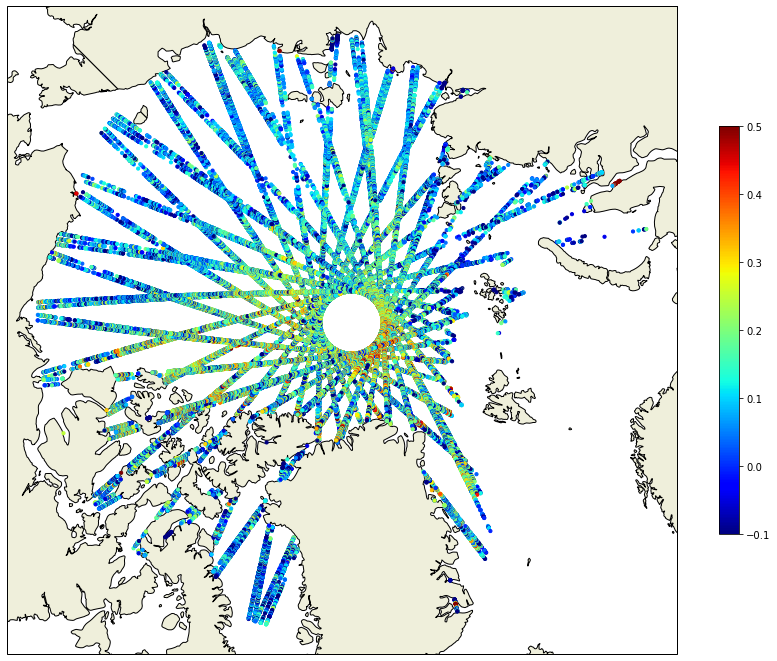

In [6]:
plt_stp = 2
# get hi-res landmask
land_50m = cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='face',
                                        facecolor=cfeature.COLORS['land'])
plt.figure(figsize=(15,15))
ax = plt.axes(projection=dst_crs)
ax.add_feature(land_50m, zorder=0, edgecolor='black')
gpi = odf['c'] > 0
sct = ax.scatter(odf['x'][gpi][::plt_stp], odf['y'][gpi][::plt_stp], 10, odf['f'][gpi][::plt_stp], cmap='jet', vmin=-.1, vmax=.5)
plt.colorbar(sct, ax=ax, shrink=0.5)
plt.show()

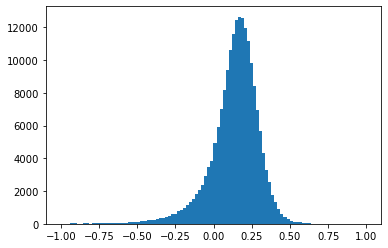

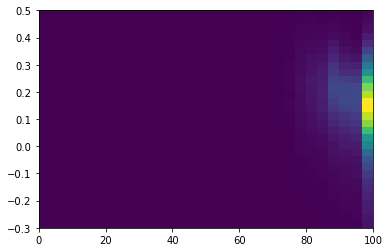

In [7]:
plt.hist(odf['f'], 100)
plt.show()

plt.hist2d(odf['c'][gpi], odf['f'][gpi], 30, [[0, 100], [-0.3, 0.5]])
plt.show()

In [8]:
# smooth over 90 km, subsample to 10 km
# for fitting ice and snow densities
sat_speed = 6576.1337527911755
sat_time_smooth = int(np.ceil(90000 / sat_speed))
sat_time_resample = int(np.ceil(10000 / sat_speed))

odf_filt = odf.rolling(f'{sat_time_smooth}s').mean().resample(f'{sat_time_resample}s').mean().dropna()
h_filt = odf_filt['h'].to_numpy()
f_filt = odf_filt['f'].to_numpy()
s_filt = odf_filt['s'].to_numpy()
x_filt = odf_filt['x'].to_numpy()
y_filt = odf_filt['y'].to_numpy()

print(sat_time_smooth, sat_time_resample, y_filt.size)

#mask = (odf.index > '01.01.2021T01:44:00') & (odf.index < '01.01.2021T01:46:00')
#plt.plot(odf[mask]['x'], odf[mask]['h'], 'o')
#mask = (odf_90_10.index > '01.01.2021T01:44:00') & (odf_90_10.index < '01.01.2021T01:46:00')
#plt.plot(odf_90_10[mask]['x'], odf_90_10[mask]['h'], '.')


14 2 13178


In [9]:
dst_xmin = -3000000
dst_ymin = -3000000
dst_xmax = 3000000
dst_ymax = 3000000
dst_res = 6000
dst_width = int((dst_xmax - dst_xmin) / dst_res)
dst_height = int((dst_ymax - dst_ymin) / dst_res)
dst_extent = [dst_xmin, dst_ymin, dst_xmax, dst_ymax]
dst_proj4_string = '+proj=stere +lat_0=90 +lat_ts=70 +lon_0=-45 +x_0=0 +y_0=0 +a=6378273 +rf=298.27940986765 +units=m +no_defs +type=crs'

dst_area = AreaDefinition('area_id', 'descr', 'proj_id', dst_proj4_string, dst_width, dst_height, dst_extent)

orb_cols, orb_rows = dst_area.get_array_coordinates_from_projection_coordinates(x_filt, y_filt)
orb_rows = np.floor(orb_rows).astype(int)
orb_cols = np.floor(orb_cols).astype(int)

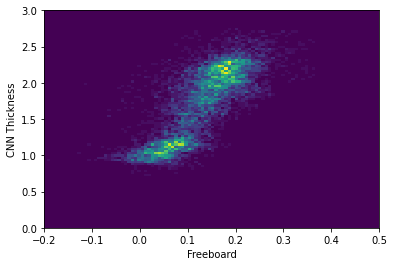

In [11]:
sit_cnn = np.load('/data1/antonk/dto_sit_nn/sit_nn_20210301.npy')
sit_raw = np.load('/Data/sim/antonk/sat_data_4cnn/sic_sit_def_20210301.npz')['sit']

orb_sit_cnn = sit_cnn[orb_rows, orb_cols]

plt.hist2d(f_filt, orb_sit_cnn, 100, [[-0.2, 0.5], [0, 3]])
plt.xlabel('Freeboard')
plt.ylabel('CNN Thickness')
plt.show()

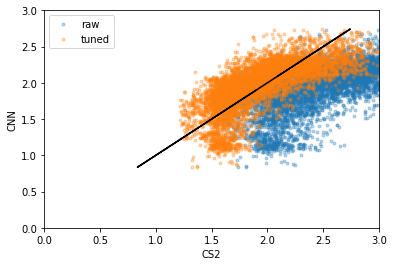

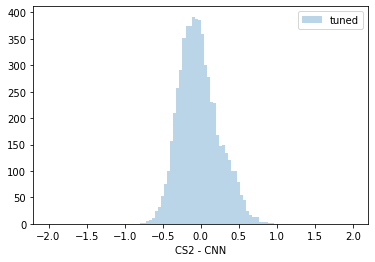

917 400
836.0792711262237 700.4453983769159


In [15]:
gpi = np.isfinite(orb_sit_cnn*f_filt*s_filt*h_filt)*(f_filt > 0.1)
                  
A = np.vstack([f_filt[gpi], s_filt[gpi]]).T
B = np.linalg.lstsq(A, orb_sit_cnn[gpi], rcond=None)[0]
h_filt_new = np.dot(A, B)

plt.plot(h_filt[gpi], orb_sit_cnn[gpi], '.', alpha=0.3, label='raw')
plt.plot(h_filt_new, orb_sit_cnn[gpi], '.', alpha=0.3, label='tuned')
plt.plot(orb_sit_cnn[gpi], orb_sit_cnn[gpi], 'k-')
plt.xlim([0, 3])
plt.ylim([0, 3])
plt.ylabel('CNN')
plt.xlabel('CS2')
plt.legend()
plt.show()


plt.hist(h_filt_new - orb_sit_cnn[gpi], 100, [-2, 2], alpha=0.3, label='tuned')
plt.xlabel('CS2 - CNN')
plt.legend()
plt.show()

rho_ice_new = rho_water*(B[0] - 1) / B[0]
rho_snow_new = B[1] * (rho_water - rho_ice_new)
print(rho_ice, rho_snow)
print(rho_ice_new, rho_snow_new)

1 1 23576


/data1/antonk/miniconda/envs/ice/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/data1/antonk/miniconda/envs/ice/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


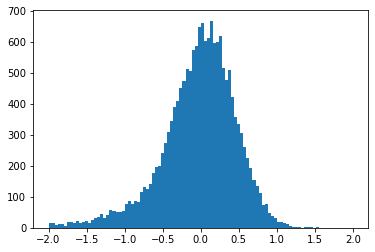

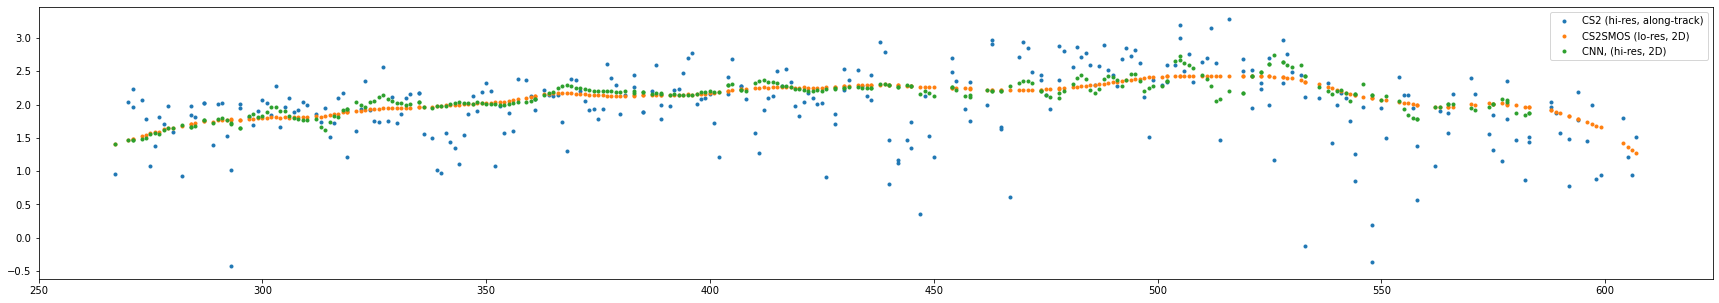

In [72]:
# smooth over 15 km, subsample to 10 km
# for computing statistics
# TODO: check at which resolution to smooth to be comparable to CNN output
sat_speed = 6576.1337527911755
sat_time_smooth = int(np.ceil(5000 / sat_speed))
sat_time_resample = int(np.ceil(5000 / sat_speed))

odf_filt = odf.rolling(f'{sat_time_smooth}s').median().resample(f'{sat_time_resample}s').mean().dropna()
f_filt = odf_filt['f'].to_numpy()
s_filt = odf_filt['s'].to_numpy()
x_filt = odf_filt['x'].to_numpy()
y_filt = odf_filt['y'].to_numpy()

h_filt = (f_filt * rho_water + s_filt * rho_snow_new) / (rho_water - rho_ice_new)

print(sat_time_smooth, sat_time_resample, y_filt.size)

orb_cols, orb_rows = dst_area.get_array_coordinates_from_projection_coordinates(x_filt, y_filt)
orb_rows = np.floor(orb_rows).astype(int)
orb_cols = np.floor(orb_cols).astype(int)

orb_sit_cnn = sit_cnn[orb_rows, orb_cols]
orb_sit_raw = sit_raw[orb_rows, orb_cols]

plt.hist(h_filt - orb_sit_cnn, 100, [-2, 2])
plt.show()

plt.figure(figsize=(30,5))
plt_c0,plt_c1=0,300
plt.plot(orb_cols[plt_c0:plt_c1], h_filt[plt_c0:plt_c1], '.', label='CS2 (hi-res, along-track)')
plt.plot(orb_cols[plt_c0:plt_c1], orb_sit_raw[plt_c0:plt_c1], '.', label='CS2SMOS (lo-res, 2D)')
plt.plot(orb_cols[plt_c0:plt_c1], orb_sit_cnn[plt_c0:plt_c1], '.', label='CNN, (hi-res, 2D)')
plt.legend()
plt.show()


/data1/antonk/miniconda/envs/ice/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in less


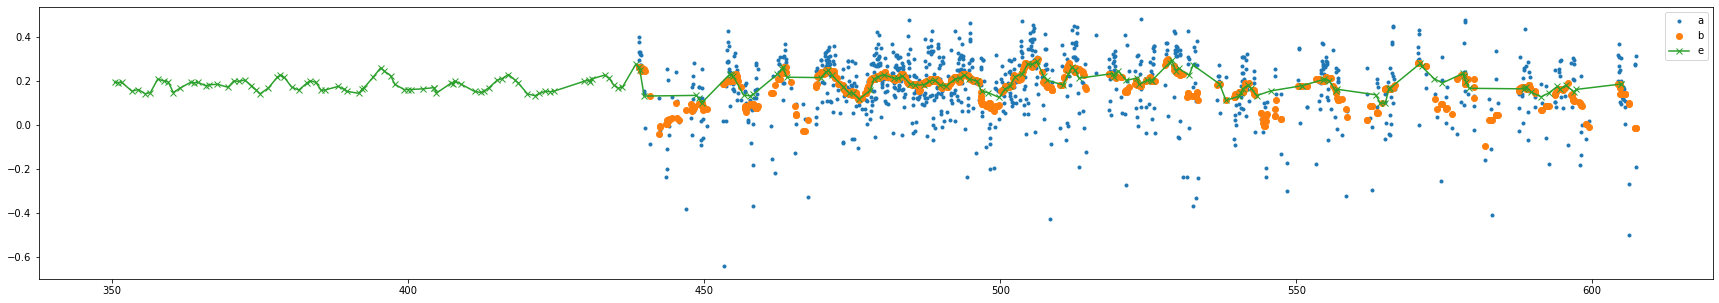

In [162]:
# smooth over 15 km, subsample to 10 km
# for computing statistics
# TODO: check at which resolution to smooth to be comparable to CNN output
sat_speed = 6576.1337527911755
sat_time_smooth = int(np.ceil(5000 / sat_speed))
sat_time_resample = int(np.ceil(5000 / sat_speed))

smth_time = '3s'
min_periods = 5

odf_a = odf#.rolling('20ms', center=True).mean() #.resample('20ms').mean()
odf_b = odf.rolling(smth_time, min_periods=min_periods, center=True).mean()#.resample('20ms').mean()
odf_c = odf.rolling(smth_time, min_periods=min_periods, center=True).std() #.resample('20ms').mean()

f_filt_a = odf_a['f'].to_numpy()
x_filt_a = odf_a['x'].to_numpy()
y_filt_a = odf_a['y'].to_numpy()
c_filt_a, r_filt_a = dst_area.get_array_coordinates_from_projection_coordinates(x_filt_a, y_filt_a)

f_filt_b = odf_b['f'].to_numpy()
x_filt_b = odf_a['x'].to_numpy()
y_filt_b = odf_a['y'].to_numpy()
c_filt_b, r_filt_b = dst_area.get_array_coordinates_from_projection_coordinates(x_filt_b, y_filt_b)

f_filt_c = odf_c['f'].to_numpy()

mask = np.abs(f_filt_a - f_filt_c) < 2 * f_filt_b

odf_d = odf[mask].rolling(smth_time, min_periods=min_periods, center=True).mean()#.resample('3s').mean()
f_filt_d = odf_d['f'].to_numpy()
x_filt_d = odf_d['x'].to_numpy()
y_filt_d = odf_d['y'].to_numpy()
c_filt_d, r_filt_d = dst_area.get_array_coordinates_from_projection_coordinates(x_filt_d, y_filt_d)

odf_e = odf[mask].rolling(smth_time, min_periods=min_periods, center=True).mean().resample('1s').mean().dropna()
f_filt_e = odf_e['f'].to_numpy()
x_filt_e = odf_e['x'].to_numpy()
y_filt_e = odf_e['y'].to_numpy()
c_filt_e, r_filt_e = dst_area.get_array_coordinates_from_projection_coordinates(x_filt_e, y_filt_e)


plt.figure(figsize=(30,5))
plt_c0,plt_c1=0,1000

plt.plot(c_filt_a[plt_c0:plt_c1], f_filt_a[plt_c0:plt_c1], '.', label='a')
plt.plot(c_filt_b[plt_c0:plt_c1], f_filt_b[plt_c0:plt_c1], 'o', label='b')
#plt.plot(c_filt_b[plt_c0:plt_c1], 1-mask[plt_c0:plt_c1], '.', label='c')
#plt.plot(c_filt_d[plt_c0:plt_c1], f_filt_d[plt_c0:plt_c1], '.', label='d')
plt.plot(c_filt_e[plt_c0:200], f_filt_e[plt_c0:200], 'x-', label='e')

plt.legend()
plt.show()

s_filt_e = odf_e['s'].to_numpy()
h_filt = (f_filt_e * rho_water + s_filt_e * rho_snow_new) / (rho_water - rho_ice_new)
orb_rows = np.floor(r_filt_e).astype(int)
orb_cols = np.floor(c_filt_e).astype(int)

orb_sit_cnn = sit_cnn[orb_rows, orb_cols]
orb_sit_raw = sit_raw[orb_rows, orb_cols]


In [163]:
grd_p_cs2 = np.zeros((dst_height, dst_width, 5)) + np.nan
grd_p_cnn = np.zeros((dst_height, dst_width, 5)) + np.nan
grd_p_raw = np.zeros((dst_height, dst_width, 5)) + np.nan

grd_m_cs2 = np.zeros((dst_height, dst_width, 1)) + np.nan
grd_m_cnn = np.zeros((dst_height, dst_width, 1)) + np.nan
grd_m_raw = np.zeros((dst_height, dst_width, 1)) + np.nan

ws = 5
stp = 10
for r in range(ws, dst_height - ws, stp):
    for c in range(ws, dst_width - ws, stp):
        gpi = np.isfinite(h_filt*orb_sit_cnn) * (orb_rows >= r) * (orb_rows < r+ws)* (orb_cols >= c) * (orb_cols < c+ws)
        if gpi[gpi].size > 0:
            grd_m_cs2[r,c,0] = np.mean(h_filt[gpi])
            grd_m_cnn[r,c,0] = np.mean(orb_sit_cnn[gpi])
            grd_m_raw[r,c,0] = np.mean(orb_sit_raw[gpi])

            for p in range(5):
                grd_p_cs2[r,c,p] = np.percentile(h_filt[gpi], 10*(p+1))
                grd_p_cnn[r,c,p] = np.percentile(orb_sit_cnn[gpi], 10*(p+1))
                grd_p_raw[r,c,p] = np.percentile(orb_sit_raw[gpi], 10*(p+1))


/data1/antonk/miniconda/envs/ice/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  from ipykernel import kernelapp as app


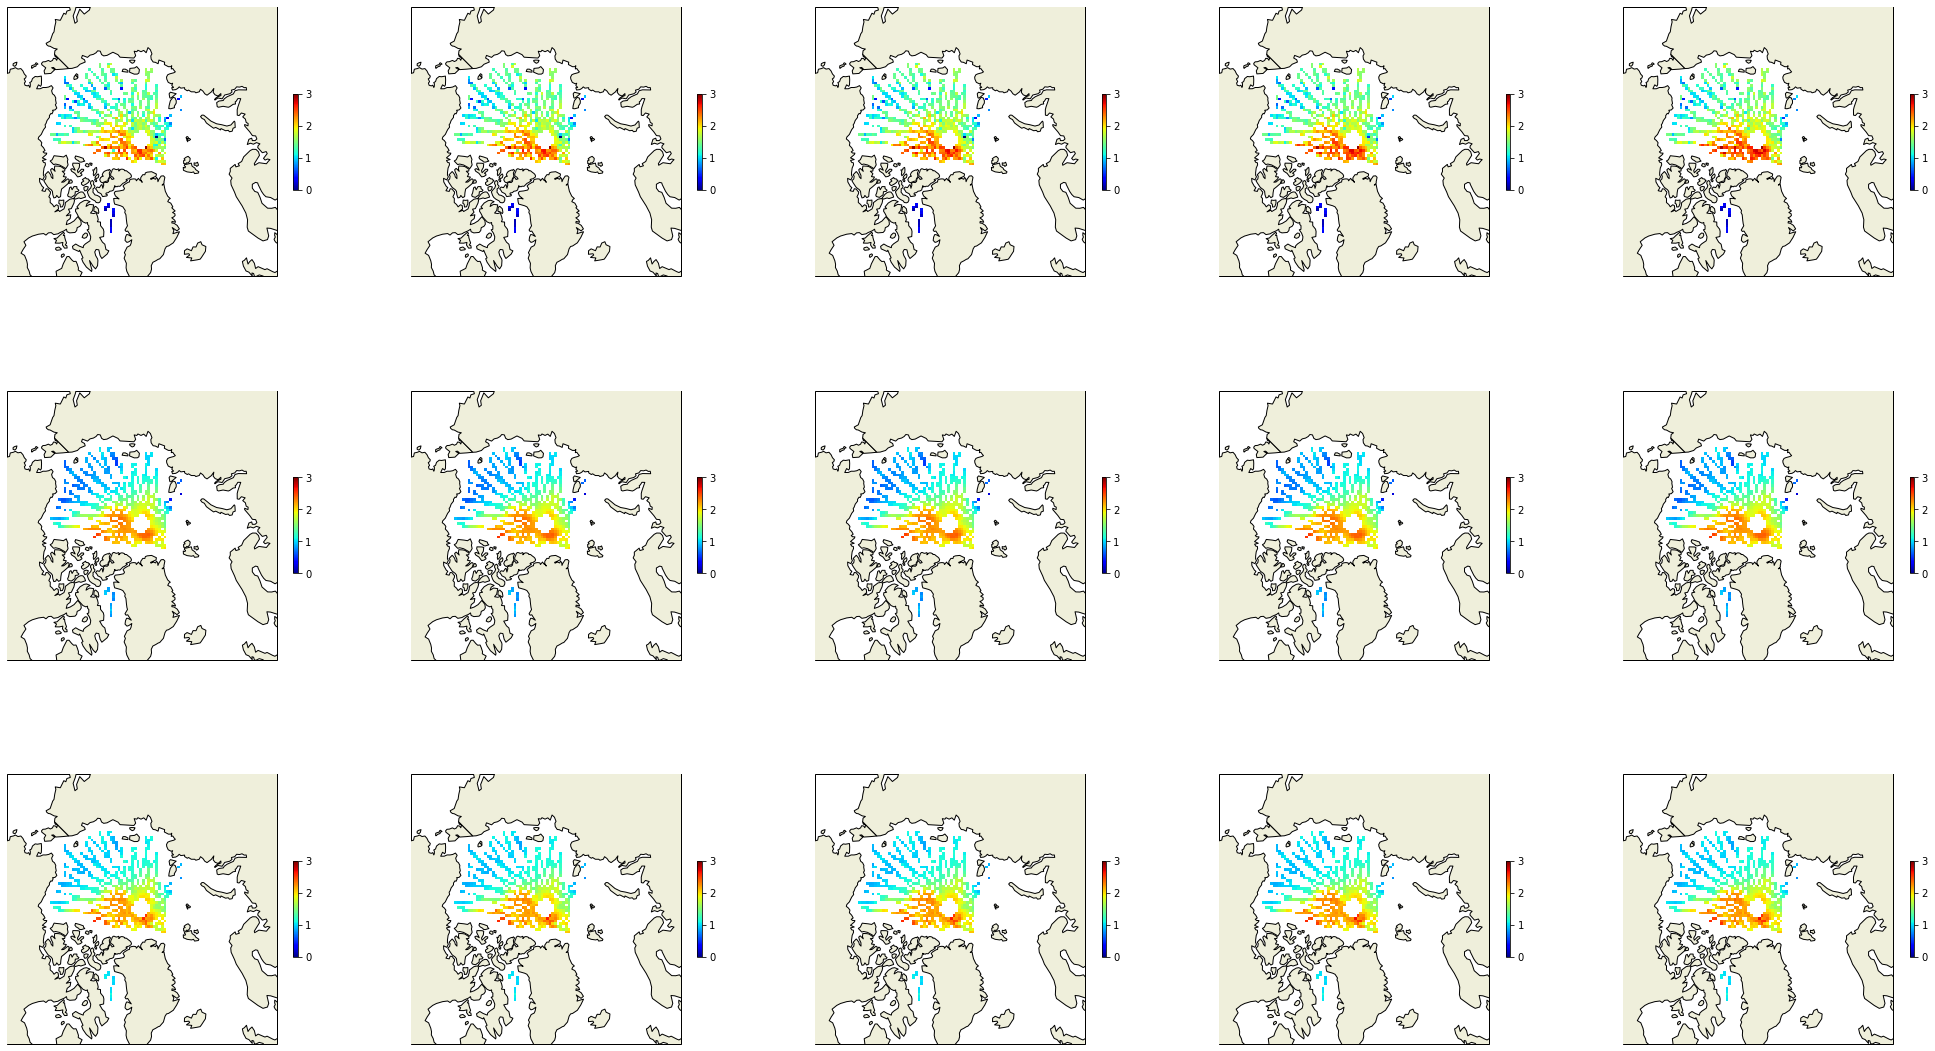

In [51]:
img_extent = [dst_xmin, dst_xmax, dst_ymax, dst_ymin]
fig_xlim = [dst_xmin, dst_xmax]
fig_ylim = [dst_ymin, dst_ymax]

fig, ax = plt.subplots(3,5, figsize=(35,20), subplot_kw=dict(projection=dst_crs))
for p in range(5):
    for i, arr in enumerate([grd_p_cs2, grd_p_raw, grd_p_cnn]):
        img = ax[i, p].imshow(arr[ws::stp, ws::stp,p], interpolation='nearest', clim=[0, 3], extent=img_extent, cmap='jet')
        fig.colorbar(img, ax = ax[i, p], shrink = 0.3)

for a in ax.flat:
    a.add_feature(cfeature.LAND, zorder=10, edgecolor='black')
    a.set_xlim(fig_xlim)
    a.set_ylim(fig_ylim)
plt.tight_layout()
plt.show()

/data1/antonk/miniconda/envs/ice/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  from ipykernel import kernelapp as app


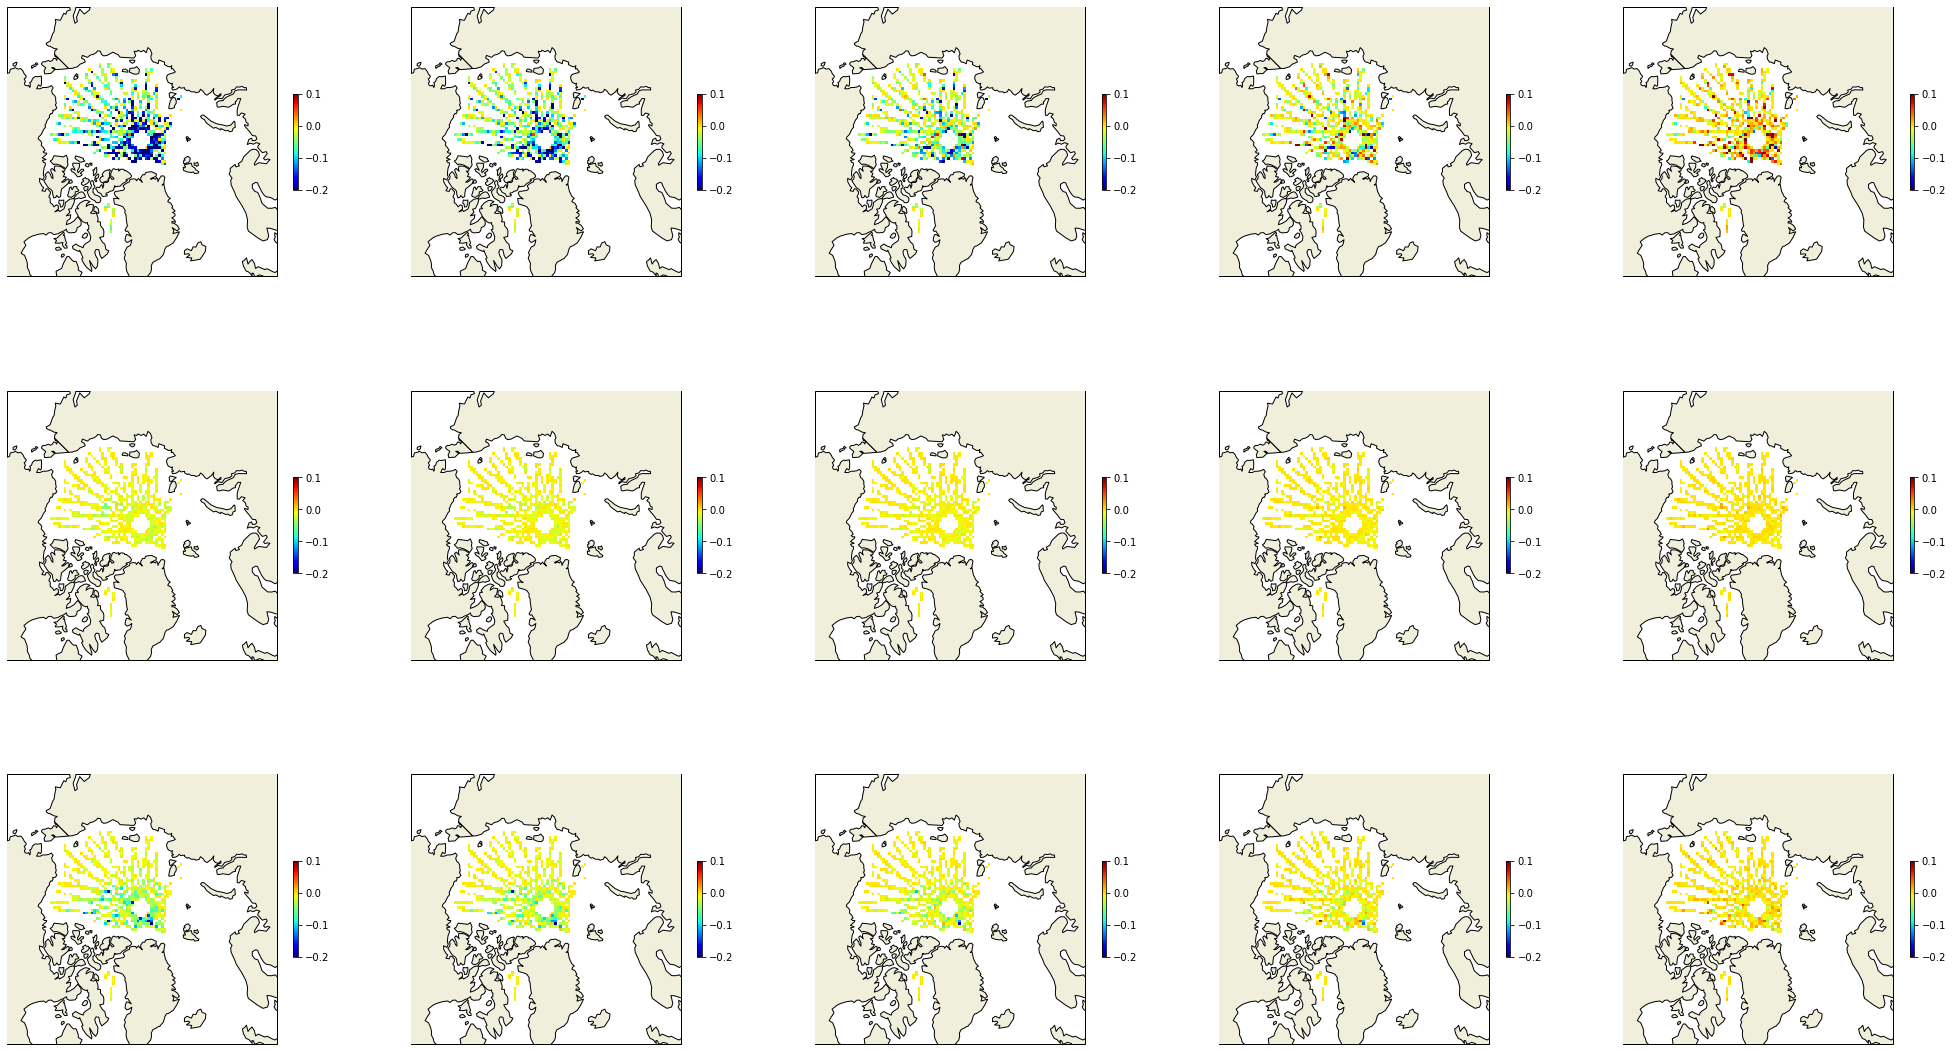

In [67]:
img_extent = [dst_xmin, dst_xmax, dst_ymax, dst_ymin]
fig_xlim = [dst_xmin, dst_xmax]
fig_ylim = [dst_ymin, dst_ymax]

fig, ax = plt.subplots(3,5, figsize=(35,20), subplot_kw=dict(projection=dst_crs))
for p in range(5):
    for i, arr in enumerate([grd_p_cs2-grd_m_cs2, grd_p_raw-grd_m_raw, grd_p_cnn-grd_m_cnn]):
        img = ax[i, p].imshow(arr[ws::stp, ws::stp,p], interpolation='nearest', clim=[-.2, .1], extent=img_extent, cmap='jet')
        fig.colorbar(img, ax = ax[i, p], shrink = 0.3)

for a in ax.flat:
    a.add_feature(cfeature.LAND, zorder=10, edgecolor='black')
    a.set_xlim(fig_xlim)
    a.set_ylim(fig_ylim)
plt.tight_layout()
plt.show()

/data1/antonk/miniconda/envs/ice/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  from ipykernel import kernelapp as app


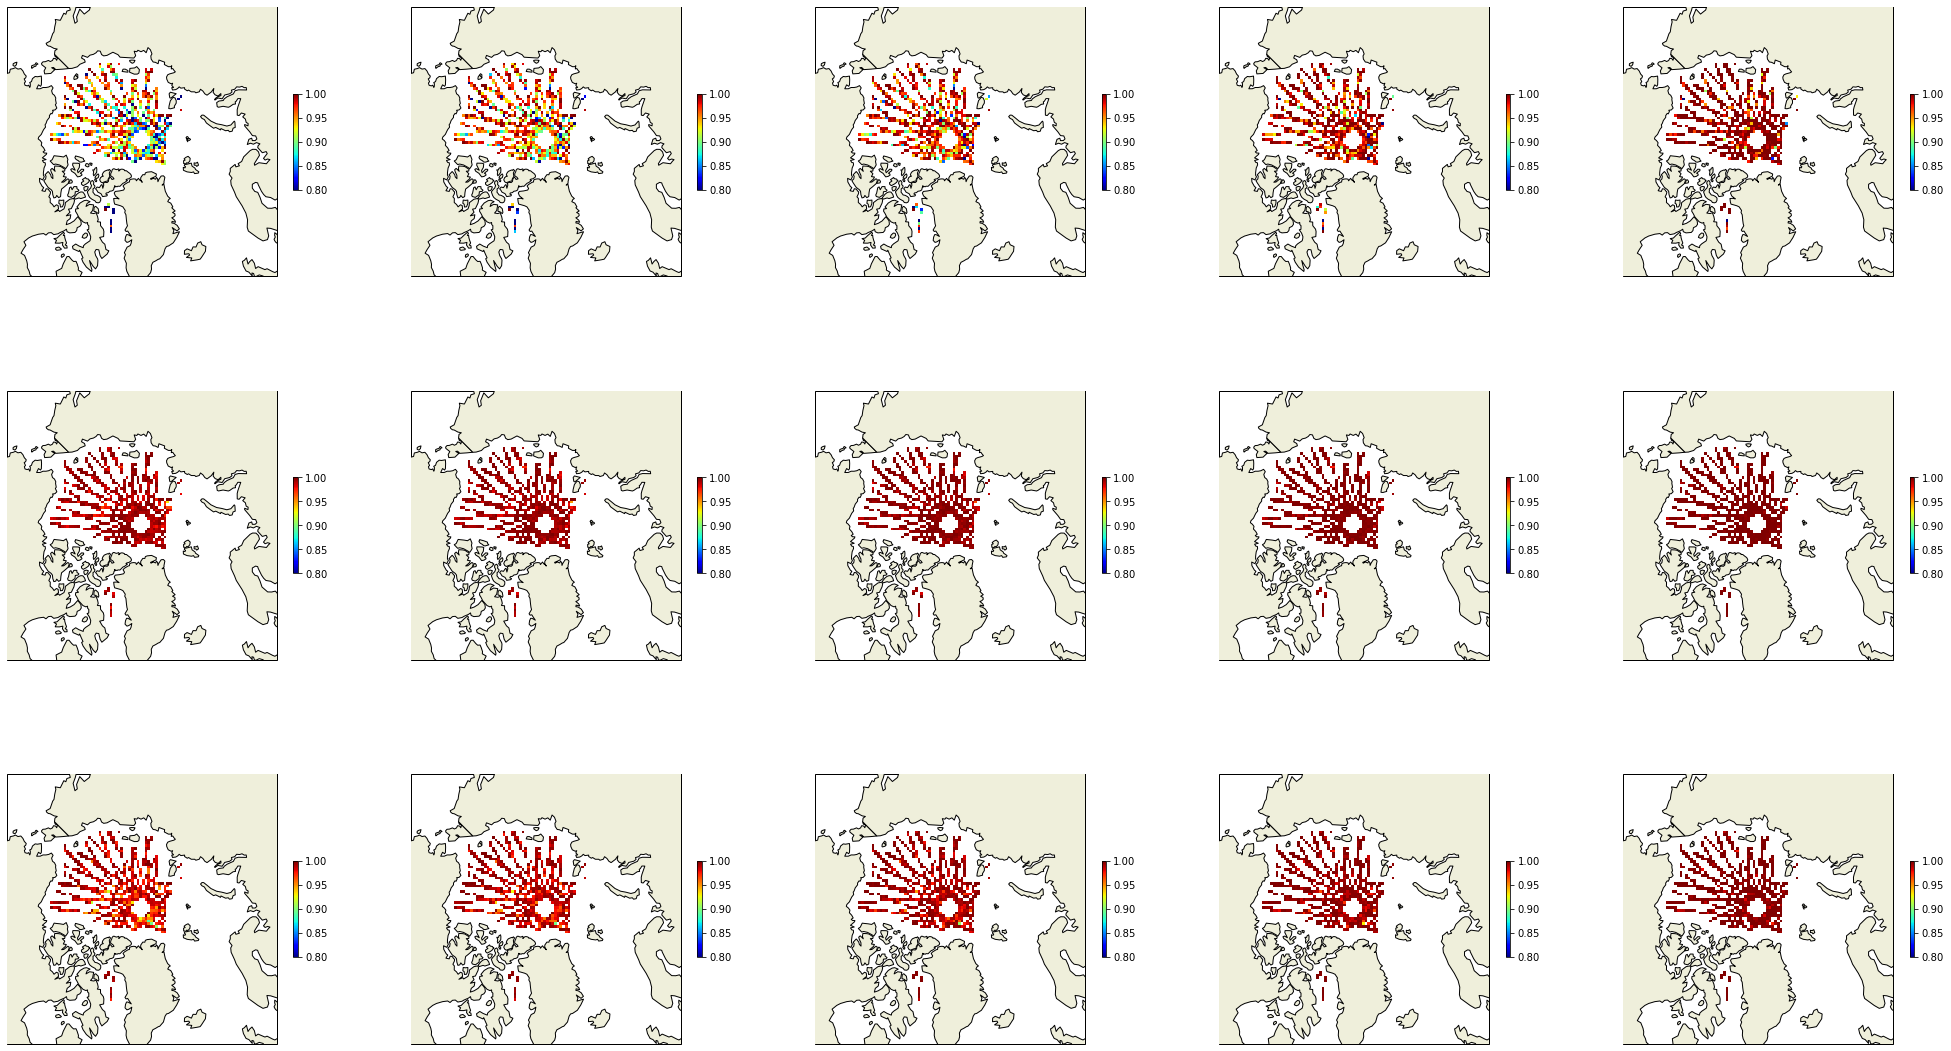

In [40]:
img_extent = [dst_xmin, dst_xmax, dst_ymax, dst_ymin]
fig_xlim = [dst_xmin, dst_xmax]
fig_ylim = [dst_ymin, dst_ymax]

fig, ax = plt.subplots(3,5, figsize=(35,20), subplot_kw=dict(projection=dst_crs))
for p in range(5):
    for i, arr in enumerate([grd_p_cs2/grd_m_cs2, grd_p_raw/grd_m_raw, grd_p_cnn/grd_m_cnn]):
        img = ax[i, p].imshow(arr[ws::stp, ws::stp,p], interpolation='nearest', clim=[0.8, 1], extent=img_extent, cmap='jet')
        fig.colorbar(img, ax = ax[i, p], shrink = 0.3)

for a in ax.flat:
    a.add_feature(cfeature.LAND, zorder=10, edgecolor='black')
    a.set_xlim(fig_xlim)
    a.set_ylim(fig_ylim)
plt.tight_layout()
plt.show()